### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Fetching and visualising Data

In [2]:
# Training data
with open('train_image.pkl', 'rb') as f: 
    imgData = pickle.load(f)
with open('train_label.pkl', 'rb') as f:
    imgLabels = pickle.load(f)

In [3]:
imgData = np.array(imgData)
imgLabels = np.array(imgLabels)
print(imgData.shape)
print(imgLabels.shape)

(8000, 784)
(8000,)


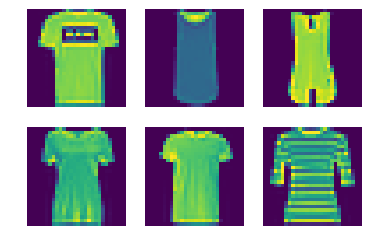

In [4]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(imgData[i].reshape(28,28))
    plt.axis("off")

In [5]:
# As we are later going to convert labels array to array of One-Hot vectors, so we have to change the labels so as to get max value of label = total no. of classes
print(np.unique(imgLabels)) 
for i in range(imgLabels.shape[0]):
    imgLabels[i] = np.ceil(imgLabels[i]/2)
print(np.unique(imgLabels))

[0 2 3 6]
[0 1 2 3]


In [6]:
# As Convolutional layer takes image as input, we have to convert given 1D array to 28 X 28 image
def preprocessData(X,Y):
    X = X.reshape((-1,28,28,1))
    X = X/255.0
    Y = to_categorical(Y) # Converting yTrain to one Hot vector i.e label 0 will be represented as [1 0]
    return X,Y

XTrain,YTrain = preprocessData(imgData,imgLabels)
print(XTrain.shape,YTrain.shape)

(8000, 28, 28, 1) (8000, 4)


In [29]:
XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.3, random_state=35, shuffle=True, stratify=YTrain)
YTrain = np.array(YTrain,dtype='int64')
YTest = np.array(YTest,dtype='int64')
print(XTrain.shape,YTrain.shape,XTest.shape,YTest.shape)

(4480, 28, 28, 1) (4480, 4) (1920, 28, 28, 1) (1920, 4)


### Training CNN Model

In [30]:
#early stopping is used to prevent overfitting i.e trainig is stopped as soon as we get the best accuracy or least loss
earlyStopping = EarlyStopping(min_delta = 0.001,monitor='val_acc', patience = 5)
callback = [earlyStopping]

#checkpoint to store the best fit model
checkpoint = ModelCheckpoint("best_model.h5",monitor='val_loss',verbose=True,save_best_only=True)

model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)))
# MaxPool layer is used to reduce the params/no. of features and get the feature with max value from the filter window
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3)) # It's used to prevent overfitting by randomly removing some neurons in each epoch(reduce overfitting)
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 128)         0         
__________

In [31]:
# Using Callbacks for earlyStopping and checkpoint
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(XTrain,YTrain,batch_size=32,epochs=100,shuffle=True,validation_split=0.2,callbacks=[checkpoint,earlyStopping])

Train on 3584 samples, validate on 896 samples
Epoch 1/100
3584/3584 [==============================] - 9s 2ms/step - loss: 0.8587 - acc: 0.6225 - val_loss: 0.7042 - val_acc: 0.6618

Epoch 00001: val_loss improved from inf to 0.70420, saving model to best_model.h5
Epoch 2/100
3584/3584 [==============================] - 8s 2ms/step - loss: 0.6247 - acc: 0.7360 - val_loss: 0.6237 - val_acc: 0.7578

Epoch 00002: val_loss improved from 0.70420 to 0.62373, saving model to best_model.h5
Epoch 3/100
3584/3584 [==============================] - 9s 2ms/step - loss: 0.5400 - acc: 0.7899 - val_loss: 0.5123 - val_acc: 0.8080

Epoch 00003: val_loss improved from 0.62373 to 0.51229, saving model to best_model.h5
Epoch 4/100
3584/3584 [==============================] - 8s 2ms/step - loss: 0.5118 - acc: 0.7893 - val_loss: 0.4864 - val_acc: 0.8136

Epoch 00004: val_loss improved from 0.51229 to 0.48638, saving model to best_model.h5
Epoch 5/100
3584/3584 [==============================] - 8s 2ms/step 

### Predicting and Evaluating

In [32]:
model.load_weights('best_model.h5')
model.evaluate(XTest,YTest)

1920/1920 [==============================] - 1s 568us/step


[0.35394259802997113, 0.8635416666666667]

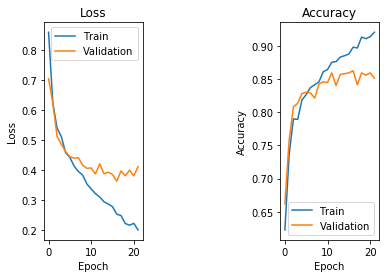

In [33]:
# Visualising Loss and Accuracy
plt.subplot(1,3,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train', 'Validation'])

plt.subplot(1,3,3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Train', 'Validation'])
plt.show()

In [34]:
predXTrain = model.predict_classes(XTrain)
predXTest = model.predict_classes(XTest)
# Converting One-Hot vectors to orignal form
YTrainActual = np.argmax(YTrain,axis=1) 
YTestActual = np.argmax(YTest,axis=1)

In [35]:
cnfTrain = confusion_matrix(predXTrain,YTrainActual)
cnfTest = confusion_matrix(predXTest,YTestActual)

In [36]:
# Function ot visualize confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Confusion Matrix for Train Data

Confusion matrix, without normalization
[[1035    9   13   84]
 [   6 1064    5   66]
 [  16    5 1085   21]
 [  63   42   17  949]]


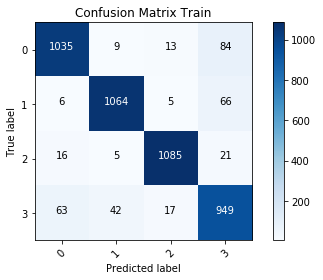

In [37]:
plot_confusion_matrix(cnfTrain,classes=[0,1,2,3],title="Confusion Matrix Train")

#### Confusion Matrix for Test Data

Confusion matrix, without normalization
[[408   6  15  60]
 [ 12 444   2  50]
 [  9   4 452  16]
 [ 51  26  11 354]]


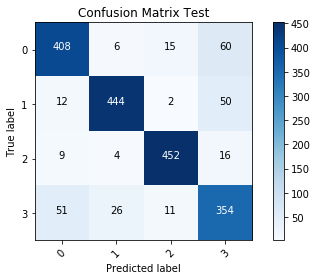

In [38]:
plot_confusion_matrix(cnfTest,classes=[0,1,2,3],title="Confusion Matrix Test")

In [39]:
print(classification_report(predXTest,YTestActual))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       489
           1       0.93      0.87      0.90       508
           2       0.94      0.94      0.94       481
           3       0.74      0.80      0.77       442

   micro avg       0.86      0.86      0.86      1920
   macro avg       0.86      0.86      0.86      1920
weighted avg       0.87      0.86      0.86      1920



#### F1-score = 0.86

### Generating Submission File

In [40]:
# Testing Data
with open('test_image.pkl', 'rb') as f:
    testData = pickle.load(f)

(2000, 784)


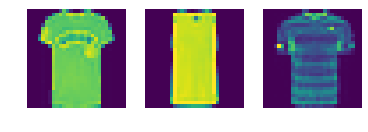

In [41]:
testData = np.array(testData)
print(testData.shape)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(testData[i].reshape(28,28))
    plt.axis("off")

In [42]:
XTest = testData.reshape((-1,28,28,1))
XTest = XTest/255.0
print(XTest.shape)

(2000, 28, 28, 1)


In [43]:
prediction = model.predict_classes(XTest) 

In [44]:
for i in range (prediction.shape[0]):
    if(prediction[i] == 1):
        prediction[i] = 2
    elif(prediction[i] == 2):
        prediction[i] = 3
    elif(prediction[i] == 3):
        prediction[i] = 6

In [49]:
predDF = pd.DataFrame(prediction)
predDF.columns = ['Predicted Labels']
predDF.head()

,Predicted Labels
0,0
1,0
2,0
3,0
4,0


In [51]:
predDF.to_csv("kapil_gupta.csv")